In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import cv2

import time
from os import makedirs
from os.path import join, exists
#from equi2pers_v3 import equi2pers
import time

## F define

### equi2pers

In [2]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def uv2xyz(uv):
    xyz = np.zeros((*uv.shape[:-1], 3), dtype = np.float32)
    xyz[..., 0] = np.multiply(np.cos(uv[..., 1]), np.sin(uv[..., 0]))
    xyz[..., 1] = np.multiply(np.cos(uv[..., 1]), np.cos(uv[..., 0]))
    xyz[..., 2] = np.sin(uv[..., 1])
    return xyz

def equi2pers(erp_img, fov, nrows, patch_size):
    bs, _, erp_h, erp_w = erp_img.shape
    height, width = pair(patch_size)
    fov_h, fov_w = pair(fov)
    FOV = torch.tensor([fov_w/360.0, fov_h/180.0], dtype=torch.float32)

    PI = math.pi
    PI_2 = math.pi * 0.5
    PI2 = math.pi * 2
    yy, xx = torch.meshgrid(torch.linspace(0, 1, height), torch.linspace(0, 1, width))
    screen_points = torch.stack([xx.flatten(), yy.flatten()], -1)
    
    if nrows==4:    
        num_rows = 4
        num_cols = [3, 6, 6, 3]
        phi_centers = [-67.5, -22.5, 22.5, 67.5]
    if nrows==6:    
        num_rows = 6
        num_cols = [3, 8, 12, 12, 8, 3]
        phi_centers = [-75.2, -45.93, -15.72, 15.72, 45.93, 75.2]
    if nrows==3:
        num_rows = 3
        num_cols = [3, 4, 3]
        phi_centers = [-60, 0, 60]     
    if nrows==5:
        num_rows = 5
        num_cols = [3, 6, 8, 6, 3]
        phi_centers = [-72.2, -36.1, 0, 36.1, 72.2]
            
    phi_interval = 180 // num_rows
    all_combos = [] #  center points(theta, phi) Per patch
    erp_mask = [] #  Masking region Per Patch
    for i, n_cols in enumerate(num_cols):
        for j in np.arange(n_cols):
            theta_interval = 360 / n_cols
            theta_center = j * theta_interval + theta_interval / 2

            center = [theta_center, phi_centers[i]]
            all_combos.append(center)
            up = phi_centers[i] + phi_interval / 2
            down = phi_centers[i] - phi_interval / 2
            left = theta_center - theta_interval / 2
            right = theta_center + theta_interval / 2
            up = int((up + 90) / 180 * erp_h)
            down = int((down + 90) / 180 * erp_h)
            left = int(left / 360 * erp_w)
            right = int(right / 360 * erp_w)
            mask = np.zeros((erp_h, erp_w), dtype=int)
            mask[down:up, left:right] = 1
            erp_mask.append(mask)
    all_combos = np.vstack(all_combos) 
    shifts = np.arange(all_combos.shape[0]) * width
    shifts = torch.from_numpy(shifts).float()
    erp_mask = np.stack(erp_mask)
    erp_mask = torch.from_numpy(erp_mask).float()
    num_patch = all_combos.shape[0]

    center_point = torch.from_numpy(all_combos).float()  # -180 to 180, -90 to 90
    center_point[:, 0] = (center_point[:, 0]) / 360  #0 to 1
    center_point[:, 1] = (center_point[:, 1] + 90) / 180  #0 to 1

    cp = center_point * 2 - 1
    center_p = cp.clone()
    cp[:, 0] = cp[:, 0] * PI
    cp[:, 1] = cp[:, 1] * PI_2
    cp = cp.unsqueeze(1)
    convertedCoord = screen_points * 2 - 1
    convertedCoord[:, 0] = convertedCoord[:, 0] * PI
    convertedCoord[:, 1] = convertedCoord[:, 1] * PI_2
    convertedCoord = convertedCoord * (torch.ones(screen_points.shape, dtype=torch.float32) * FOV)
    convertedCoord = convertedCoord.unsqueeze(0).repeat(cp.shape[0], 1, 1)

    x = convertedCoord[:, :, 0]
    y = convertedCoord[:, :, 1]

    rou = torch.sqrt(x ** 2 + y ** 2)
    c = torch.atan(rou)
    sin_c = torch.sin(c)
    cos_c = torch.cos(c)
    lat = torch.asin(cos_c * torch.sin(cp[:, :, 1]) + (y * sin_c * torch.cos(cp[:, :, 1])) / rou)
    lon = cp[:, :, 0] + torch.atan2(x * sin_c, rou * torch.cos(cp[:, :, 1]) * cos_c - y * torch.sin(cp[:, :, 1]) * sin_c)
    lat_new = lat / PI_2 
    lon_new = lon / PI 
    lon_new[lon_new > 1] -= 2
    lon_new[lon_new<-1] += 2 

    lon_new = lon_new.view(1, num_patch, height, width).permute(0, 2, 1, 3).contiguous().view(height, num_patch*width)
    lat_new = lat_new.view(1, num_patch, height, width).permute(0, 2, 1, 3).contiguous().view(height, num_patch*width)
    grid = torch.stack([lon_new, lat_new], -1)
    grid = grid.unsqueeze(0).repeat(bs, 1, 1, 1).to(erp_img.device)

    pers = F.grid_sample(erp_img, grid, mode='bilinear', padding_mode='border', align_corners=True)
    pers = F.unfold(pers, kernel_size=(height, width), stride=(height, width))
    pers = pers.reshape(bs, -1, height, width, num_patch)
  
    grid_tmp = torch.stack([lon, lat], -1)
    xyz = uv2xyz(grid_tmp)
    xyz = xyz.reshape(num_patch, height, width, 3).transpose(0, 3, 1, 2)
    xyz = torch.from_numpy(xyz).to(pers.device).contiguous()
    
    uv = grid[0, ...].reshape(height, width, num_patch, 2).permute(2, 3, 0, 1)
    uv = uv.contiguous()
    return pers, xyz, uv, center_p

### equi2pers non ideal

In [3]:
def equi2pers_non_ideal(erp_img, fov, nrows, patch_size):
    bs, _, erp_h, erp_w = erp_img.shape
    height, width = pair(patch_size)
    fov_h, fov_w = pair(fov)
    FOV = torch.tensor([fov_w/360.0, fov_h/180.0], dtype=torch.float32)

    PI = math.pi
    PI_2 = math.pi * 0.5
    PI2 = math.pi * 2
    yy, xx = torch.meshgrid(torch.linspace(0, 1, height), torch.linspace(0, 1, width))
    screen_points = torch.stack([xx.flatten(), yy.flatten()], -1)
    
    if nrows==4:    
        num_rows = 4
        num_cols = [3, 6, 6, 3]
        phi_centers = [-67.5, -22.5, 22.5, 67.5]
    if nrows==6:    
        num_rows = 6
        num_cols = [3, 8, 12, 12, 8, 3]
        phi_centers = [-75.2, -45.93, -15.72, 15.72, 45.93, 75.2]
    if nrows==3:
        num_rows = 3
        num_cols = [3, 4, 3]
        phi_centers = [-60, 0, 60]     
    if nrows==5:
        num_rows = 5
        num_cols = [3, 6, 8, 6, 3]
        phi_centers = [-72.2, -36.1, 0, 36.1, 72.2]
            
    phi_interval = 180 // num_rows
    all_combos = [] #  center points(theta, phi) Per patch
    erp_mask = [] #  Masking region Per Patch
    for i, n_cols in enumerate(num_cols):
        for j in np.arange(n_cols):
            theta_interval = 360 / n_cols
            theta_center = j * theta_interval + theta_interval / 2

            center = [theta_center, phi_centers[i]]
            all_combos.append(center)
            up = phi_centers[i] + phi_interval / 2
            down = phi_centers[i] - phi_interval / 2
            left = theta_center - theta_interval / 2
            right = theta_center + theta_interval / 2
            up = int((up + 90) / 180 * erp_h)
            down = int((down + 90) / 180 * erp_h)
            left = int(left / 360 * erp_w)
            right = int(right / 360 * erp_w)
            mask = np.zeros((erp_h, erp_w), dtype=int)
            mask[down:up, left:right] = 1
            erp_mask.append(mask)
    all_combos = np.vstack(all_combos) 
    shifts = np.arange(all_combos.shape[0]) * width
    shifts = torch.from_numpy(shifts).float()
    erp_mask = np.stack(erp_mask)
    erp_mask = torch.from_numpy(erp_mask).float()
    num_patch = all_combos.shape[0]

    ### Non-ideal case
    # all_combos[3] = [50, -22.5]
    # all_combos[4] = [110, -22.5]
    # all_combos[5] = [140, -22.5]
    # all_combos[6] = [190, -22.5]
    ### Automatically 
    randoms = np.random.uniform(-30, 30, all_combos.shape)
    all_combos += randoms
    
    
    center_point = torch.from_numpy(all_combos).float()  # -180 to 180, -90 to 90
    center_point[:, 0] = (center_point[:, 0]) / 360  #0 to 1
    center_point[:, 1] = (center_point[:, 1] + 90) / 180  #0 to 1

    cp = center_point * 2 - 1
    center_p = cp.clone()
    cp[:, 0] = cp[:, 0] * PI
    cp[:, 1] = cp[:, 1] * PI_2
    cp = cp.unsqueeze(1)
    convertedCoord = screen_points * 2 - 1
    convertedCoord[:, 0] = convertedCoord[:, 0] * PI
    convertedCoord[:, 1] = convertedCoord[:, 1] * PI_2
    convertedCoord = convertedCoord * (torch.ones(screen_points.shape, dtype=torch.float32) * FOV)
    convertedCoord = convertedCoord.unsqueeze(0).repeat(cp.shape[0], 1, 1)

    x = convertedCoord[:, :, 0]
    y = convertedCoord[:, :, 1]

    rou = torch.sqrt(x ** 2 + y ** 2)
    c = torch.atan(rou)
    sin_c = torch.sin(c)
    cos_c = torch.cos(c)
    lat = torch.asin(cos_c * torch.sin(cp[:, :, 1]) + (y * sin_c * torch.cos(cp[:, :, 1])) / rou)
    lon = cp[:, :, 0] + torch.atan2(x * sin_c, rou * torch.cos(cp[:, :, 1]) * cos_c - y * torch.sin(cp[:, :, 1]) * sin_c)
    lat_new = lat / PI_2 
    lon_new = lon / PI 
    lon_new[lon_new > 1] -= 2
    lon_new[lon_new<-1] += 2 

    lon_new = lon_new.view(1, num_patch, height, width).permute(0, 2, 1, 3).contiguous().view(height, num_patch*width)
    lat_new = lat_new.view(1, num_patch, height, width).permute(0, 2, 1, 3).contiguous().view(height, num_patch*width)
    grid = torch.stack([lon_new, lat_new], -1)
    grid = grid.unsqueeze(0).repeat(bs, 1, 1, 1).to(erp_img.device)

    pers = F.grid_sample(erp_img, grid, mode='bilinear', padding_mode='border', align_corners=True)
    pers = F.unfold(pers, kernel_size=(height, width), stride=(height, width))
    pers = pers.reshape(bs, -1, height, width, num_patch)
  
    grid_tmp = torch.stack([lon, lat], -1)
    xyz = uv2xyz(grid_tmp)
    xyz = xyz.reshape(num_patch, height, width, 3).transpose(0, 3, 1, 2)
    xyz = torch.from_numpy(xyz).to(pers.device).contiguous()
    
    uv = grid[0, ...].reshape(height, width, num_patch, 2).permute(2, 3, 0, 1)
    uv = uv.contiguous()
    return pers, xyz, uv, center_p

### Pers2equi

In [4]:
def pers2equi(pers_img, fov, nrows, patch_size, erp_size, layer_name):
    bs = pers_img.shape[0]
    channel = pers_img.shape[1]
    device=pers_img.device
    height, width = pair(patch_size)
    fov_h, fov_w = pair(fov)
    erp_h, erp_w = pair(erp_size)
    n_patch = pers_img.shape[-1]     
    # grid_dir = './grid'
    # if not exists(grid_dir):
    #     makedirs(grid_dir)
    grid_file = join(layer_name + '.pth')  
    
    if not exists(grid_file):  
        FOV = torch.tensor([fov_w/360.0, fov_h/180.0], dtype=torch.float32)

        PI = math.pi
        PI_2 = math.pi * 0.5
        PI2 = math.pi * 2

        if nrows==4:    
            num_rows = 4
            num_cols = [3, 6, 6, 3]
            phi_centers = [-67.5, -22.5, 22.5, 67.5]
        if nrows==6:    
            num_rows = 6
            num_cols = [3, 8, 12, 12, 8, 3]
            phi_centers = [-75.2, -45.93, -15.72, 15.72, 45.93, 75.2]
        if nrows==3:
            num_rows = 3
            num_cols = [3, 4, 3]
            phi_centers = [-59.6, 0, 59.6]
        if nrows==5:
            num_rows = 5
            num_cols = [3, 6, 8, 6, 3]
            phi_centers = [-72.2, -36.1, 0, 36.1, 72.2] 
        phi_interval = 180 // num_rows
        all_combos = []

        for i, n_cols in enumerate(num_cols):
            for j in np.arange(n_cols):
                theta_interval = 360 / n_cols
                theta_center = j * theta_interval + theta_interval / 2

                center = [theta_center, phi_centers[i]]
                all_combos.append(center)
                
                
        all_combos = np.vstack(all_combos) 
        n_patch = all_combos.shape[0]
        
        ## patch center point normalizing to -1 to 1 & radian conversion [−π,π] for longitude and [−π/2,π/2] for latitude
        center_point = torch.from_numpy(all_combos).float()  # -180 to 180, -90 to 90
        center_point[:, 0] = (center_point[:, 0]) / 360  #0 to 1
        center_point[:, 1] = (center_point[:, 1] + 90) / 180  #0 to 1

        cp = center_point * 2 - 1 #-1 to 1
        cp[:, 0] = cp[:, 0] * PI
        cp[:, 1] = cp[:, 1] * PI_2
        cp = cp.unsqueeze(1)
        """
        lat_grid, lon_grid = torch.meshgrid(torch.linspace(-PI_2, PI_2, erp_h), torch.linspace(-PI, PI, erp_w))
        lon_grid = lon_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1)
        lat_grid = lat_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1) 

        cos_c = torch.sin(cp[..., 1]) * torch.sin(lat_grid) + torch.cos(cp[..., 1]) * torch.cos(lat_grid) * torch.cos(lon_grid - cp[..., 0])
        new_x = (torch.cos(lat_grid) * torch.sin(lon_grid - cp[..., 0])) / cos_c
        new_y = (torch.cos(cp[..., 1])*torch.sin(lat_grid) - torch.sin(cp[...,1])*torch.cos(lat_grid)*torch.cos(lon_grid-cp[...,0])) / cos_c
        new_x = new_x / FOV[0] / PI   # -1 to 1
        new_y = new_y / FOV[1] / PI_2    

        new_x = (new_x + 1) * 0.5 * height
        new_y = (new_y + 1) * 0.5 * width
        new_x = new_x.reshape(num_patch, erp_h, erp_w) 
        new_y = new_y.reshape(num_patch, erp_h, erp_w) 

        new_x = new_x + shifts.reshape(-1, 1, 1)

        new_x *= erp_mask
        new_y *= erp_mask
        new_x = new_x.sum(0)
        new_y = new_y.sum(0)

        new_x = (new_x / pers_img.shape[-1] - 0.5) * 2
        new_y = (new_y / pers_img.shape[-2] - 0.5) * 2

        new_grid = torch.stack([new_x, new_y], -1)
        torch.save(new_grid, grid_file)
    else:
        new_grid = torch.load(grid_file)    
    new_grid = new_grid.unsqueeze(0).repeat(bs, 1, 1, 1).to(pers_img.device)
    img_erp = F.grid_sample(pers_img, new_grid, mode='bilinear', padding_mode='border', align_corners=True)
        """
        
        lat_grid, lon_grid = torch.meshgrid(torch.linspace(-PI_2, PI_2, erp_h), torch.linspace(-PI, PI, erp_w)) #[−π,π] for longitude and [−π/2,π/2] for latitude
        lon_grid = lon_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1) 
        lat_grid = lat_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1) 
        cos_c = torch.sin(cp[..., 1]) * torch.sin(lat_grid) + torch.cos(cp[..., 1]) * torch.cos(lat_grid) * torch.cos(lon_grid - cp[..., 0])
        new_x = (torch.cos(lat_grid) * torch.sin(lon_grid - cp[..., 0])) / cos_c
        new_y = (torch.cos(cp[..., 1])*torch.sin(lat_grid) - torch.sin(cp[...,1])*torch.cos(lat_grid)*torch.cos(lon_grid-cp[...,0])) / cos_c
        new_x = new_x / FOV[0] / PI   # -1 to 1
        new_y = new_y / FOV[1] / PI_2
        cos_c_mask = cos_c.reshape(n_patch, erp_h, erp_w)
        cos_c_mask = torch.where(cos_c_mask > 0, 1, 0)
        
        #biliner interpolation
        w_list = torch.zeros((n_patch, erp_h, erp_w, 4), dtype=torch.float32)

        new_x_patch = (new_x + 1) * 0.5 * height # 0 to h
        new_y_patch = (new_y + 1) * 0.5 * width  # 0 to W
        new_x_patch = new_x_patch.reshape(n_patch, erp_h, erp_w)
        new_y_patch = new_y_patch.reshape(n_patch, erp_h, erp_w)
        mask = torch.where((new_x_patch < width) & (new_x_patch > 0) & (new_y_patch < height) & (new_y_patch > 0), 1, 0) #patch가 이미지 경계에 있는지
        mask *= cos_c_mask #, 시야각에 있는지 확인

        x0 = torch.floor(new_x_patch).type(torch.int64)
        x1 = x0 + 1
        y0 = torch.floor(new_y_patch).type(torch.int64)
        y1 = y0 + 1

        x0 = torch.clamp(x0, 0, width-1)
        x1 = torch.clamp(x1, 0, width-1)
        y0 = torch.clamp(y0, 0, height-1)
        y1 = torch.clamp(y1, 0, height-1)
        #interpolation weights 계산
        wa = (x1.type(torch.float32)-new_x_patch) * (y1.type(torch.float32)-new_y_patch)
        wb = (x1.type(torch.float32)-new_x_patch) * (new_y_patch-y0.type(torch.float32))
        wc = (new_x_patch-x0.type(torch.float32)) * (y1.type(torch.float32)-new_y_patch)
        wd = (new_x_patch-x0.type(torch.float32)) * (new_y_patch-y0.type(torch.float32))

        wa = wa * mask.expand_as(wa)
        wb = wb * mask.expand_as(wb)
        wc = wc * mask.expand_as(wc)
        wd = wd * mask.expand_as(wd)

        w_list[..., 0] = wa
        w_list[..., 1] = wb
        w_list[..., 2] = wc
        w_list[..., 3] = wd

       
        save_file = {'x0':x0, 'y0':y0, 'x1':x1, 'y1':y1, 'w_list': w_list, 'mask':mask}
        #torch.save(save_file, grid_file)
    else:
        # the online merge really takes time
        # pre-calculate the grid for once and use it during training
        load_file = torch.load(grid_file)
        #print('load_file')
        x0 = load_file['x0']
        y0 = load_file['y0']
        x1 = load_file['x1']
        y1 = load_file['y1']
        w_list = load_file['w_list']
        mask = load_file['mask']

    w_list = w_list.to(device)
    mask = mask.to(device)
    z = torch.arange(n_patch)
    z = z.reshape(n_patch, 1, 1)
    #start = time.time()
    Ia = pers_img[:, :, y0, x0, z]
    Ib = pers_img[:, :, y1, x0, z]
    Ic = pers_img[:, :, y0, x1, z]
    Id = pers_img[:, :, y1, x1, z]
    #print(time.time() - start)
    output_a = Ia * mask.expand_as(Ia)
    output_b = Ib * mask.expand_as(Ib)
    output_c = Ic * mask.expand_as(Ic)
    output_d = Id * mask.expand_as(Id)

    output_a = output_a.permute(0, 1, 3, 4, 2)
    output_b = output_b.permute(0, 1, 3, 4, 2)
    output_c = output_c.permute(0, 1, 3, 4, 2)
    output_d = output_d.permute(0, 1, 3, 4, 2)   
    #print(time.time() - start)
    w_list = w_list.permute(1, 2, 0, 3)
    w_list = w_list.flatten(2)
    w_list *= torch.gt(w_list, 1e-5).type(torch.float32)
    w_list = F.normalize(w_list, p=1, dim=-1).reshape(erp_h, erp_w, n_patch, 4)
    w_list = w_list.unsqueeze(0).unsqueeze(0)
    output = output_a * w_list[..., 0] + output_b * w_list[..., 1] + \
        output_c * w_list[..., 2] + output_d * w_list[..., 3]
    img_erp = output.sum(-1) ### erp patch 18개의 총합산

    return img_erp


### pers2equi nonideal

In [5]:
def pers2equi_non_ideal(pers_img, fov, nrows, patch_size, erp_size, layer_name, cp_random):
    bs = pers_img.shape[0]
    channel = pers_img.shape[1]
    device=pers_img.device
    height, width = pair(patch_size)
    fov_h, fov_w = pair(fov)
    erp_h, erp_w = pair(erp_size)
    n_patch = pers_img.shape[-1]     
    
    FOV = torch.tensor([fov_w/360.0, fov_h/180.0], dtype=torch.float32)

    PI = math.pi
    PI_2 = math.pi * 0.5
    PI2 = math.pi * 2

    if nrows==4:    
        num_rows = 4
        num_cols = [3, 6, 6, 3]
        phi_centers = [-67.5, -22.5, 22.5, 67.5]
    if nrows==6:    
        num_rows = 6
        num_cols = [3, 8, 12, 12, 8, 3]
        phi_centers = [-75.2, -45.93, -15.72, 15.72, 45.93, 75.2]
    if nrows==3:
        num_rows = 3
        num_cols = [3, 4, 3]
        phi_centers = [-59.6, 0, 59.6]
    if nrows==5:
        num_rows = 5
        num_cols = [3, 6, 8, 6, 3]
        phi_centers = [-72.2, -36.1, 0, 36.1, 72.2] 
    phi_interval = 180 // num_rows
    all_combos = []

    for i, n_cols in enumerate(num_cols):
        for j in np.arange(n_cols):
            theta_interval = 360 / n_cols
            theta_center = j * theta_interval + theta_interval / 2

            center = [theta_center, phi_centers[i]]
            all_combos.append(center)
            
            
    all_combos = np.vstack(all_combos) 
    ###all_combos = all_combos[[0, 4, 5, 7]]
    n_patch = all_combos.shape[0]
    
    # ### Non-ideal case
    # all_combos[3] = [50, -22.5]
    # all_combos[4] = [110, -22.5]
    # all_combos[5] = [140, -22.5]
    # all_combos[6] = [190, -22.5]
    
    ## patch center point normalizing to -1 to 1 & radian conversion [−π,π] for longitude and [−π/2,π/2] for latitude
    center_point = torch.from_numpy(all_combos).float()  # -180 to 180, -90 to 90
    center_point[:, 0] = (center_point[:, 0]) / 360  #0 to 1
    center_point[:, 1] = (center_point[:, 1] + 90) / 180  #0 to 1

    cp = center_point * 2 - 1 #-1 to 1
    
    ### Random replace
    cp = cp_random
    
    cp[:, 0] = cp[:, 0] * PI
    cp[:, 1] = cp[:, 1] * PI_2
    cp = cp.unsqueeze(1)
    
    lat_grid, lon_grid = torch.meshgrid(torch.linspace(-PI_2, PI_2, erp_h), torch.linspace(-PI, PI, erp_w)) #[−π,π] for longitude and [−π/2,π/2] for latitude
    lon_grid = lon_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1) 
    lat_grid = lat_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1) 
    cos_c = torch.sin(cp[..., 1]) * torch.sin(lat_grid) + torch.cos(cp[..., 1]) * torch.cos(lat_grid) * torch.cos(lon_grid - cp[..., 0])
    new_x = (torch.cos(lat_grid) * torch.sin(lon_grid - cp[..., 0])) / cos_c
    new_y = (torch.cos(cp[..., 1])*torch.sin(lat_grid) - torch.sin(cp[...,1])*torch.cos(lat_grid)*torch.cos(lon_grid-cp[...,0])) / cos_c
    new_x = new_x / FOV[0] / PI   # -1 to 1
    new_y = new_y / FOV[1] / PI_2
    cos_c_mask = cos_c.reshape(n_patch, erp_h, erp_w)
    cos_c_mask = torch.where(cos_c_mask > 0, 1, 0)
    
    #biliner interpolation
    w_list = torch.zeros((n_patch, erp_h, erp_w, 4), dtype=torch.float32)

    new_x_patch = (new_x + 1) * 0.5 * height # 0 to h
    new_y_patch = (new_y + 1) * 0.5 * width  # 0 to W
    new_x_patch = new_x_patch.reshape(n_patch, erp_h, erp_w)
    new_y_patch = new_y_patch.reshape(n_patch, erp_h, erp_w)
    mask = torch.where((new_x_patch < width) & (new_x_patch > 0) & (new_y_patch < height) & (new_y_patch > 0), 1, 0) #patch가 이미지 경계에 있는지
    mask *= cos_c_mask #, 시야각에 있는지 확인

    x0 = torch.floor(new_x_patch).type(torch.int64)
    x1 = x0 + 1
    y0 = torch.floor(new_y_patch).type(torch.int64)
    y1 = y0 + 1

    x0 = torch.clamp(x0, 0, width-1)
    x1 = torch.clamp(x1, 0, width-1)
    y0 = torch.clamp(y0, 0, height-1)
    y1 = torch.clamp(y1, 0, height-1)
    #interpolation weights 계산
    wa = (x1.type(torch.float32)-new_x_patch) * (y1.type(torch.float32)-new_y_patch)
    wb = (x1.type(torch.float32)-new_x_patch) * (new_y_patch-y0.type(torch.float32))
    wc = (new_x_patch-x0.type(torch.float32)) * (y1.type(torch.float32)-new_y_patch)
    wd = (new_x_patch-x0.type(torch.float32)) * (new_y_patch-y0.type(torch.float32))

    wa = wa * mask.expand_as(wa)
    wb = wb * mask.expand_as(wb)
    wc = wc * mask.expand_as(wc)
    wd = wd * mask.expand_as(wd)

    w_list[..., 0] = wa
    w_list[..., 1] = wb
    w_list[..., 2] = wc
    w_list[..., 3] = wd

       

    w_list = w_list.to(device)
    mask = mask.to(device)
    z = torch.arange(n_patch)
    z = z.reshape(n_patch, 1, 1)
    #start = time.time()
    Ia = pers_img[:, :, y0, x0, z]
    Ib = pers_img[:, :, y1, x0, z]
    Ic = pers_img[:, :, y0, x1, z]
    Id = pers_img[:, :, y1, x1, z]
    #print(time.time() - start)
    output_a = Ia * mask.expand_as(Ia)
    output_b = Ib * mask.expand_as(Ib)
    output_c = Ic * mask.expand_as(Ic)
    output_d = Id * mask.expand_as(Id)

    output_a = output_a.permute(0, 1, 3, 4, 2)
    output_b = output_b.permute(0, 1, 3, 4, 2)
    output_c = output_c.permute(0, 1, 3, 4, 2)
    output_d = output_d.permute(0, 1, 3, 4, 2)   
    #print(time.time() - start)
    w_list = w_list.permute(1, 2, 0, 3)
    w_list = w_list.flatten(2)
    w_list *= torch.gt(w_list, 1e-5).type(torch.float32)
    w_list = F.normalize(w_list, p=1, dim=-1).reshape(erp_h, erp_w, n_patch, 4)
    w_list = w_list.unsqueeze(0).unsqueeze(0)
    output = output_a * w_list[..., 0] + output_b * w_list[..., 1] + \
        output_c * w_list[..., 2] + output_d * w_list[..., 3]
    img_erp = output.sum(-1) ### erp patch 18개의 총합산

    return img_erp


In [ ]:
def pers2equi_non_ideal_auto(pers_img, fov, nrows, patch_size, erp_size, layer_name, cp_random):
    bs, _, erp_h, erp_w = pers_img.shape
    height, width = pair(patch_size)
    fov_h, fov_w = pair(fov)
    FOV = torch.tensor([fov_w/360.0, fov_h/180.0], dtype=torch.float32)

    PI = math.pi
    PI_2 = math.pi * 0.5
    PI2 = math.pi * 2
    yy, xx = torch.meshgrid(torch.linspace(0, 1, height), torch.linspace(0, 1, width))
    screen_points = torch.stack([xx.flatten(), yy.flatten()], -1)
    
    if nrows==4:    
        num_rows = 4
        num_cols = [3, 6, 6, 3]
        phi_centers = [-67.5, -22.5, 22.5, 67.5]
    if nrows==6:    
        num_rows = 6
        num_cols = [3, 8, 12, 12, 8, 3]
        phi_centers = [-75.2, -45.93, -15.72, 15.72, 45.93, 75.2]
    if nrows==3:
        num_rows = 3
        num_cols = [3, 4, 3]
        phi_centers = [-60, 0, 60]     
    if nrows==5:
        num_rows = 5
        num_cols = [3, 6, 8, 6, 3]
        phi_centers = [-72.2, -36.1, 0, 36.1, 72.2]
            
    phi_interval = 180 // num_rows
    all_combos = [] #  center points(theta, phi) Per patch
    erp_mask = [] #  Masking region Per Patch
    for i, n_cols in enumerate(num_cols):
        for j in np.arange(n_cols):
            theta_interval = 360 / n_cols
            theta_center = j * theta_interval + theta_interval / 2

            center = [theta_center, phi_centers[i]]
            all_combos.append(center)
            up = phi_centers[i] + phi_interval / 2
            down = phi_centers[i] - phi_interval / 2
            left = theta_center - theta_interval / 2
            right = theta_center + theta_interval / 2
            up = int((up + 90) / 180 * erp_h)
            down = int((down + 90) / 180 * erp_h)
            left = int(left / 360 * erp_w)
            right = int(right / 360 * erp_w)
            mask = np.zeros((erp_h, erp_w), dtype=int)
            mask[down:up, left:right] = 1
            erp_mask.append(mask)
    all_combos = np.vstack(all_combos) 
    shifts = np.arange(all_combos.shape[0]) * width
    shifts = torch.from_numpy(shifts).float()
    erp_mask = np.stack(erp_mask)
    erp_mask = torch.from_numpy(erp_mask).float()
    num_patch = all_combos.shape[0]

    center_point = torch.from_numpy(all_combos).float()  # -180 to 180, -90 to 90
    center_point[:, 0] = (center_point[:, 0]) / 360  #0 to 1
    center_point[:, 1] = (center_point[:, 1] + 90) / 180  #0 to 1

    cp = center_point * 2 - 1
    center_p = cp.clone()
    cp[:, 0] = cp[:, 0] * PI
    cp[:, 1] = cp[:, 1] * PI_2
    cp = cp.unsqueeze(1)

    lat_grid, lon_grid = torch.meshgrid(torch.linspace(-PI_2, PI_2, erp_h), torch.linspace(-PI, PI, erp_w))
    lon_grid = lon_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1)
    lat_grid = lat_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1) 

    cos_c = torch.sin(cp[..., 1]) * torch.sin(lat_grid) + torch.cos(cp[..., 1]) * torch.cos(lat_grid) * torch.cos(lon_grid - cp[..., 0])
    new_x = (torch.cos(lat_grid) * torch.sin(lon_grid - cp[..., 0])) / cos_c
    new_y = (torch.cos(cp[..., 1])*torch.sin(lat_grid) - torch.sin(cp[...,1])*torch.cos(lat_grid)*torch.cos(lon_grid-cp[...,0])) / cos_c
    new_x = new_x / FOV[0] / PI   # -1 to 1
    new_y = new_y / FOV[1] / PI_2
    print(new_x.shape, new_y.shape)

    new_x = (new_x + 1) * 0.5 * height
    new_y = (new_y + 1) * 0.5 * width
    new_x = new_x.reshape(n_patch, erp_h, erp_w) 
    new_y = new_y.reshape(n_patch, erp_h, erp_w) 

    new_x = new_x + shifts.reshape(-1, 1, 1)

    new_x *= erp_mask
    new_y *= erp_mask
    new_x = new_x.sum(0)
    new_y = new_y.sum(0)

    new_x = (new_x / persp.shape[-1] - 0.5) * 2
    new_y = (new_y / persp.shape[-2] - 0.5) * 2
    new_grid = torch.stack([new_x, new_y], -1)
    new_grid = new_grid.unsqueeze(0)
    img_erp = F.grid_sample(persp, new_grid, mode='bilinear', padding_mode='border', align_corners=True)

    return img_erp

In [6]:
def pers2equi_non_ideal_auto(pers_img, fov, nrows, patch_size, erp_size, layer_name, cp_random):
    bs = pers_img.shape[0]
    channel = pers_img.shape[1]
    device=pers_img.device
    height, width = pair(patch_size)
    fov_h, fov_w = pair(fov)
    erp_h, erp_w = pair(erp_size)
    n_patch = pers_img.shape[-1]     
    
    FOV = torch.tensor([fov_w/360.0, fov_h/180.0], dtype=torch.float32)

    PI = math.pi
    PI_2 = math.pi * 0.5
    PI2 = math.pi * 2

    if nrows==4:    
        num_rows = 4
        num_cols = [3, 6, 6, 3]
        phi_centers = [-67.5, -22.5, 22.5, 67.5]
    if nrows==6:    
        num_rows = 6
        num_cols = [3, 8, 12, 12, 8, 3]
        phi_centers = [-75.2, -45.93, -15.72, 15.72, 45.93, 75.2]
    if nrows==3:
        num_rows = 3
        num_cols = [3, 4, 3]
        phi_centers = [-59.6, 0, 59.6]
    if nrows==5:
        num_rows = 5
        num_cols = [3, 6, 8, 6, 3]
        phi_centers = [-72.2, -36.1, 0, 36.1, 72.2] 
    phi_interval = 180 // num_rows
    all_combos = []
    erp_mask = [] #  Masking region Per Patch
    for i, n_cols in enumerate(num_cols):
        for j in np.arange(n_cols):
            theta_interval = 360 / n_cols
            theta_center = j * theta_interval + theta_interval / 2

            center = [theta_center, phi_centers[i]]
            all_combos.append(center)
            
            ### Auto Mask
            up = phi_centers[i] + phi_interval / 2
            down = phi_centers[i] - phi_interval / 2
            left = theta_center - theta_interval / 2
            right = theta_center + theta_interval / 2
            up = int((up + 90) / 180 * erp_h)
            down = int((down + 90) / 180 * erp_h)
            left = int(left / 360 * erp_w)
            right = int(right / 360 * erp_w)
            mask = np.zeros((erp_h, erp_w), dtype=int)
            mask[down:up, left:right] = 1
            erp_mask.append(mask)
    all_combos = np.vstack(all_combos) 
    num_patch = all_combos.shape[0]
    n_patch = all_combos.shape[0]
    erp_mask = np.stack(erp_mask)
    erp_mask = torch.from_numpy(erp_mask).float()
    shifts = np.arange(all_combos.shape[0]) * width
    shifts = torch.from_numpy(shifts).float()
    ### Auto Mask
    
    
    
    # ### Non-ideal case
    # all_combos[3] = [50, -22.5]
    # all_combos[4] = [110, -22.5]
    # all_combos[5] = [140, -22.5]
    # all_combos[6] = [190, -22.5]
    
    ## patch center point normalizing to -1 to 1 & radian conversion [−π,π] for longitude and [−π/2,π/2] for latitude
    center_point = torch.from_numpy(all_combos).float()  # -180 to 180, -90 to 90
    center_point[:, 0] = (center_point[:, 0]) / 360  #0 to 1
    center_point[:, 1] = (center_point[:, 1] + 90) / 180  #0 to 1

    cp = center_point * 2 - 1 #-1 to 1
    
    ### Random replace
    cp = cp_random
    
    cp[:, 0] = cp[:, 0] * PI
    cp[:, 1] = cp[:, 1] * PI_2
    cp = cp.unsqueeze(1)
    
    lat_grid, lon_grid = torch.meshgrid(torch.linspace(-PI_2, PI_2, erp_h), torch.linspace(-PI, PI, erp_w)) #[−π,π] for longitude and [−π/2,π/2] for latitude
    lon_grid = lon_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1) 
    lat_grid = lat_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1) 
    cos_c = torch.sin(cp[..., 1]) * torch.sin(lat_grid) + torch.cos(cp[..., 1]) * torch.cos(lat_grid) * torch.cos(lon_grid - cp[..., 0])
    new_x = (torch.cos(lat_grid) * torch.sin(lon_grid - cp[..., 0])) / cos_c
    new_y = (torch.cos(cp[..., 1])*torch.sin(lat_grid) - torch.sin(cp[...,1])*torch.cos(lat_grid)*torch.cos(lon_grid-cp[...,0])) / cos_c
    new_x = new_x / FOV[0] / PI   # -1 to 1
    new_y = new_y / FOV[1] / PI_2
    
    new_x = (new_x + 1) * 0.5 * height
    new_y = (new_y + 1) * 0.5 * width
    new_x = new_x.reshape(num_patch, erp_h, erp_w) 
    new_y = new_y.reshape(num_patch, erp_h, erp_w) 

    new_x = new_x + shifts.reshape(-1, 1, 1)

    new_x *= erp_mask
    new_y *= erp_mask
    new_x = new_x.sum(0)
    new_y = new_y.sum(0)

    new_x = (new_x / pers_img.shape[-1] - 0.5) * 2
    new_y = (new_y / pers_img.shape[-2] - 0.5) * 2

    new_grid = torch.stack([new_x, new_y], -1)
    
    new_grid = new_grid.unsqueeze(0).repeat(bs, 1, 1, 1).to(pers_img.device)
    img_erp = F.grid_sample(pers_img.reshape(bs, 3, height, width * pers_img.shape[-1]), new_grid, mode='bilinear', padding_mode='border', align_corners=True)
    
    return img_erp

In [7]:
def pers2equi_suffled(pers_img, fov, nrows, patch_size, erp_size, layer_name, suffle):
    bs = pers_img.shape[0]
    channel = pers_img.shape[1]
    device=pers_img.device
    height, width = pair(patch_size)
    fov_h, fov_w = pair(fov)
    erp_h, erp_w = pair(erp_size)
    n_patch = pers_img.shape[-1]     
    
    FOV = torch.tensor([fov_w/360.0, fov_h/180.0], dtype=torch.float32)

    PI = math.pi
    PI_2 = math.pi * 0.5
    PI2 = math.pi * 2

    if nrows==4:    
        num_rows = 4
        num_cols = [3, 6, 6, 3]
        phi_centers = [-67.5, -22.5, 22.5, 67.5]
    if nrows==6:    
        num_rows = 6
        num_cols = [3, 8, 12, 12, 8, 3]
        phi_centers = [-75.2, -45.93, -15.72, 15.72, 45.93, 75.2]
    if nrows==3:
        num_rows = 3
        num_cols = [3, 4, 3]
        phi_centers = [-59.6, 0, 59.6]
    if nrows==5:
        num_rows = 5
        num_cols = [3, 6, 8, 6, 3]
        phi_centers = [-72.2, -36.1, 0, 36.1, 72.2] 
    phi_interval = 180 // num_rows
    all_combos = []

    for i, n_cols in enumerate(num_cols):
        for j in np.arange(n_cols):
            theta_interval = 360 / n_cols
            theta_center = j * theta_interval + theta_interval / 2

            center = [theta_center, phi_centers[i]]
            all_combos.append(center)
            
            
    all_combos = np.vstack(all_combos) 
    n_patch = all_combos.shape[0]
    ## patch center point normalizing to -1 to 1 & radian conversion [−π,π] for longitude and [−π/2,π/2] for latitude
    center_point = torch.from_numpy(all_combos).float()  # -180 to 180, -90 to 90
    center_point[:, 0] = (center_point[:, 0]) / 360  #0 to 1
    center_point[:, 1] = (center_point[:, 1] + 90) / 180  #0 to 1

    cp = center_point * 2 - 1 #-1 to 1
    cp[:, 0] = cp[:, 0] * PI
    cp[:, 1] = cp[:, 1] * PI_2
    cp = cp.unsqueeze(1)
    
    ### apply suffled information
    cp = cp[suffle]
    
    lat_grid, lon_grid = torch.meshgrid(torch.linspace(-PI_2, PI_2, erp_h), torch.linspace(-PI, PI, erp_w)) #[−π,π] for longitude and [−π/2,π/2] for latitude
    lon_grid = lon_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1) 
    lat_grid = lat_grid.float().reshape(1, -1)#.repeat(num_rows*num_cols, 1) 
    cos_c = torch.sin(cp[..., 1]) * torch.sin(lat_grid) + torch.cos(cp[..., 1]) * torch.cos(lat_grid) * torch.cos(lon_grid - cp[..., 0])
    new_x = (torch.cos(lat_grid) * torch.sin(lon_grid - cp[..., 0])) / cos_c
    new_y = (torch.cos(cp[..., 1])*torch.sin(lat_grid) - torch.sin(cp[...,1])*torch.cos(lat_grid)*torch.cos(lon_grid-cp[...,0])) / cos_c
    new_x = new_x / FOV[0] / PI   # -1 to 1
    new_y = new_y / FOV[1] / PI_2
    cos_c_mask = cos_c.reshape(n_patch, erp_h, erp_w)
    cos_c_mask = torch.where(cos_c_mask > 0, 1, 0)
    
    #biliner interpolation
    w_list = torch.zeros((n_patch, erp_h, erp_w, 4), dtype=torch.float32)

    new_x_patch = (new_x + 1) * 0.5 * height # 0 to h
    new_y_patch = (new_y + 1) * 0.5 * width  # 0 to W
    new_x_patch = new_x_patch.reshape(n_patch, erp_h, erp_w)
    new_y_patch = new_y_patch.reshape(n_patch, erp_h, erp_w)
    mask = torch.where((new_x_patch < width) & (new_x_patch > 0) & (new_y_patch < height) & (new_y_patch > 0), 1, 0) #patch가 이미지 경계에 있는지
    mask *= cos_c_mask #, 시야각에 있는지 확인

    x0 = torch.floor(new_x_patch).type(torch.int64)
    x1 = x0 + 1
    y0 = torch.floor(new_y_patch).type(torch.int64)
    y1 = y0 + 1

    x0 = torch.clamp(x0, 0, width-1)
    x1 = torch.clamp(x1, 0, width-1)
    y0 = torch.clamp(y0, 0, height-1)
    y1 = torch.clamp(y1, 0, height-1)
    #interpolation weights 계산
    wa = (x1.type(torch.float32)-new_x_patch) * (y1.type(torch.float32)-new_y_patch)
    wb = (x1.type(torch.float32)-new_x_patch) * (new_y_patch-y0.type(torch.float32))
    wc = (new_x_patch-x0.type(torch.float32)) * (y1.type(torch.float32)-new_y_patch)
    wd = (new_x_patch-x0.type(torch.float32)) * (new_y_patch-y0.type(torch.float32))

    wa = wa * mask.expand_as(wa)
    wb = wb * mask.expand_as(wb)
    wc = wc * mask.expand_as(wc)
    wd = wd * mask.expand_as(wd)

    w_list[..., 0] = wa
    w_list[..., 1] = wb
    w_list[..., 2] = wc
    w_list[..., 3] = wd

       

    w_list = w_list.to(device)
    mask = mask.to(device)
    z = torch.arange(n_patch)
    z = z.reshape(n_patch, 1, 1)
    #start = time.time()
    Ia = pers_img[:, :, y0, x0, z]
    Ib = pers_img[:, :, y1, x0, z]
    Ic = pers_img[:, :, y0, x1, z]
    Id = pers_img[:, :, y1, x1, z]
    #print(time.time() - start)
    output_a = Ia * mask.expand_as(Ia)
    output_b = Ib * mask.expand_as(Ib)
    output_c = Ic * mask.expand_as(Ic)
    output_d = Id * mask.expand_as(Id)

    output_a = output_a.permute(0, 1, 3, 4, 2)
    output_b = output_b.permute(0, 1, 3, 4, 2)
    output_c = output_c.permute(0, 1, 3, 4, 2)
    output_d = output_d.permute(0, 1, 3, 4, 2)   
    #print(time.time() - start)
    w_list = w_list.permute(1, 2, 0, 3)
    w_list = w_list.flatten(2)
    w_list *= torch.gt(w_list, 1e-5).type(torch.float32)
    w_list = F.normalize(w_list, p=1, dim=-1).reshape(erp_h, erp_w, n_patch, 4)
    w_list = w_list.unsqueeze(0).unsqueeze(0)
    output = output_a * w_list[..., 0] + output_b * w_list[..., 1] + \
        output_c * w_list[..., 2] + output_d * w_list[..., 3]
    img_erp = output.sum(-1) ### erp patch 18개의 총합산

    return img_erp


## Image Load

(248, 496, 3)


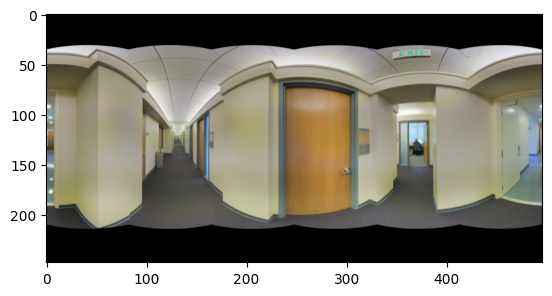

In [8]:

img_BGR = cv2.imread('../output/__erp_img.png', cv2.IMREAD_COLOR)
#img_BGR = cv2.imread('4.jpg', cv2.IMREAD_COLOR)
import matplotlib.pyplot as plt
# plt.imshow(img_BGR)
# plt.show()
img = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB) #BGR to RGB  [:,:,[2,1,0]]
print(img.shape)
plt.imshow(img) 
plt.show()


## Define Vars

In [9]:
nrows=4
npatches=18
patch_size=(128, 128)
fov=(80, 80)
erp_size=(img.shape[0], img.shape[1])
layer_name='pred' #'weight'

## Equi 2 Pers

In [10]:
img_new = img.astype(np.float32) 
img_new = np.transpose(img_new, [2, 0, 1])
img_new = torch.from_numpy(img_new)
img_new = img_new.unsqueeze(0)
print(img_new.shape)

torch.Size([1, 3, 248, 496])


In [11]:
pers, xyz, uv, center_p = equi2pers(img_new, fov=fov, nrows=nrows, patch_size=patch_size)
pers_img = pers[0].permute(3, 1, 2, 0)
pers_img = pers_img.numpy().astype(np.uint8)
print(pers_img.shape)    


(18, 128, 128, 3)


/home/sslunder0/anaconda3/envs/OmniDepth-v1-py311/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Pers Nonideal

In [12]:
pers_non, _, _, center_p = equi2pers_non_ideal(img_new, fov=fov, nrows=nrows, patch_size=patch_size)
pers_img_non = pers_non[0].permute(3, 1, 2, 0)
pers_img_non = pers_img_non.numpy().astype(np.uint8)
print(pers_img_non.shape)    

(18, 128, 128, 3)


### Pers Suffle

In [13]:

tensor = torch.tensor(range(18))
indices = torch.randperm(tensor.size(0))
shuffled_tensor = tensor[indices]

print(shuffled_tensor)

print(pers_img[shuffled_tensor].shape)

pers_img_suffle = pers_img[shuffled_tensor]


tensor([11,  4, 12,  5, 16, 13, 10,  9,  3,  0,  8,  2,  7, 17, 15,  1,  6, 14])
(18, 128, 128, 3)


### c. Plotting

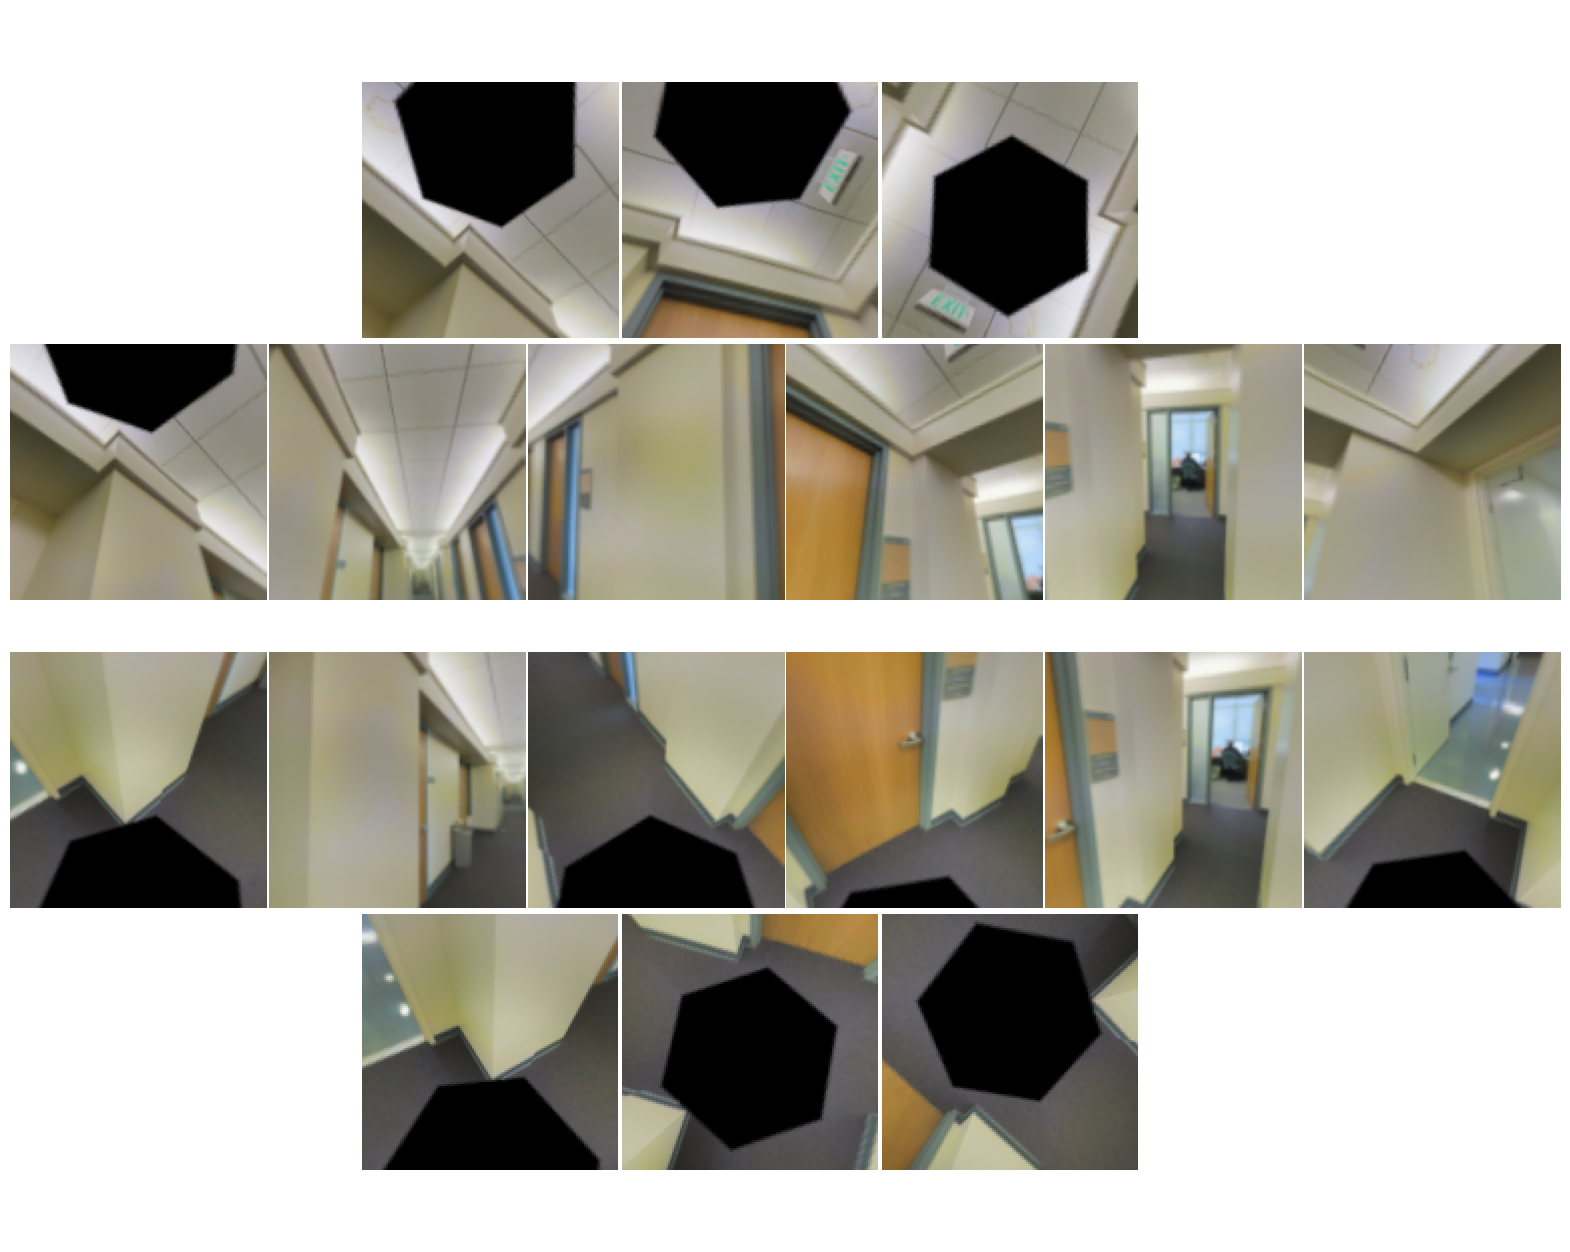

In [14]:
fig, axes = plt.subplots(4, 6, figsize=(20, 16))
fig.subplots_adjust(hspace=0, wspace=0.01)
for i in range(3):
    axes[0, i].imshow(pers_img_non[i])
    axes[3, i].imshow(pers_img_non[i+15])
for i in range(6):
    axes[1, i].imshow(pers_img_non[i+3])
    axes[2, i].imshow(pers_img_non[i+9])

for i in range(4):
    for j in range(6):
        axes[i, j].axis('off')
        pos = axes[i, j].get_position()
        #print(f"Subplot {i, j} position: x0={pos.x0:.2f}, y0={pos.y0:.2f}, width={pos.width:.2f}, height={pos.height:.2f}")

axes[0, 0].set_position([0.30, 0.675, 0.13, 0.16])
axes[0, 1].set_position([0.43, 0.675, 0.13, 0.16])
axes[0, 2].set_position([0.56, 0.675, 0.13, 0.16])
axes[3, 0].set_position([0.30, 0.155, 0.13, 0.16])
axes[3, 1].set_position([0.43, 0.155, 0.13, 0.16])
axes[3, 2].set_position([0.56, 0.155, 0.13, 0.16])
plt.show()       

## Pers 2 equi

In [15]:
pers.shape
shuffled_tensor
pers_suffled = pers[..., shuffled_tensor]
equi_suffled = pers2equi_suffled(pers_suffled, fov, nrows, patch_size, erp_size, layer_name='pred', suffle=shuffled_tensor)


In [16]:
select = [0, 4, 5, 7, 11, 14, 17]
print(pers_non.shape)
print(pers_non[..., select].shape)
equi_non = pers2equi_non_ideal(pers_non, fov, nrows, patch_size, erp_size, layer_name='pred', cp_random=center_p)

equi_non_auto = pers2equi_non_ideal_auto(pers_non, fov, nrows, patch_size, erp_size, layer_name='pred', cp_random=center_p)


torch.Size([1, 3, 128, 128, 18])
torch.Size([1, 3, 128, 128, 7])


Transform

In [17]:
print(pers.shape)
equi = pers2equi(pers_suffled, fov=fov, nrows=nrows, patch_size=patch_size, erp_size=erp_size, layer_name='pred')  
equi_w = pers2equi(pers, fov=fov, nrows=nrows, patch_size=patch_size, erp_size=erp_size, layer_name='weight') 
print(pers.shape, equi.shape)
print(f'mean: {equi.mean()}, w: {equi_w.mean()}')

torch.Size([1, 3, 128, 128, 18])
torch.Size([1, 3, 128, 128, 18]) torch.Size([1, 3, 248, 496])
mean: 121.65452575683594, w: 97.13130950927734


### c. plotting

(248, 496, 3)


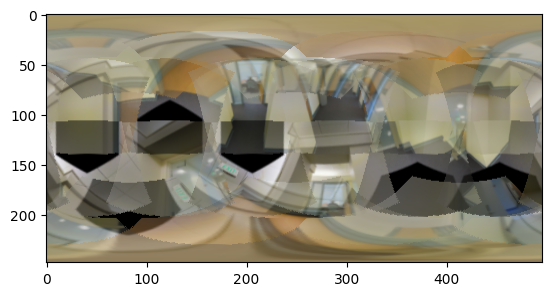

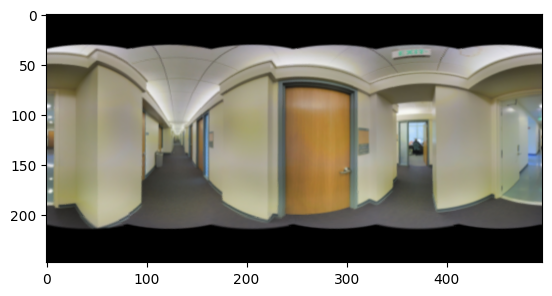

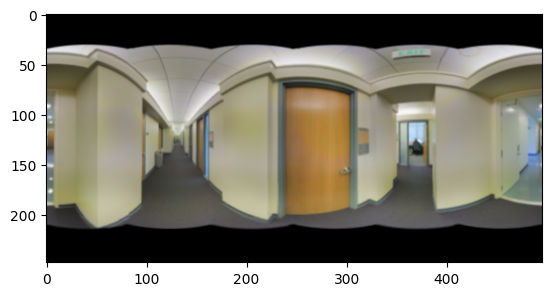

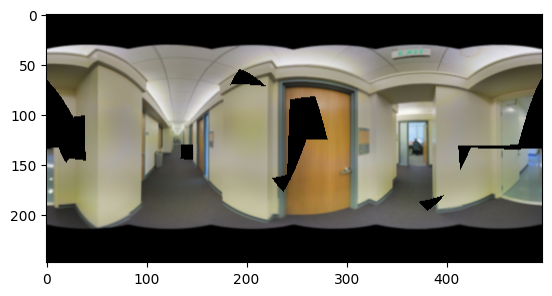

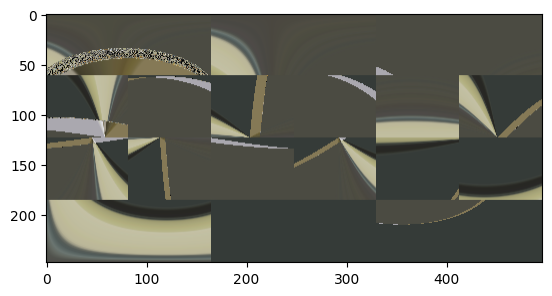

In [18]:

equi_img = equi[0].permute(1, 2, 0).numpy().astype(np.uint8)
print(equi_img.shape)
equi_w_img = equi_w[0].permute(1, 2, 0).numpy().astype(np.uint8)
equi_img_suffle= equi_suffled[0].permute(1, 2, 0).numpy().astype(np.uint8)

equi_img_non = equi_non[0].permute(1, 2, 0).numpy().astype(np.uint8)

equi_img_non_auto = equi_non_auto[0].permute(1, 2, 0).numpy().astype(np.uint8)
plt.imshow(equi_img)
plt.show()
plt.imshow(equi_w_img)
plt.show()
plt.imshow(equi_img_suffle)
plt.show()
plt.imshow(equi_img_non)
plt.show()
plt.imshow(equi_img_non_auto)
plt.show()

## Metrics

In [ ]:
import skimage.metrics as metrics
ssim_noise = metrics.structural_similarity(img, equi_img, multichannel=True, channel_axis=2) #, win_size=7 default
psnr = metrics.peak_signal_noise_ratio(img, equi_img)
mse_noise = metrics.mean_squared_error(img, equi_img)
print(f'ssim: {ssim_noise:.4f}, psnr: {psnr:.4f}, mse: {mse_noise:.4f}')

ssim: 0.2577, psnr: 11.6025, mse: 4496.0481


In [ ]:
ssim_noise = metrics.structural_similarity(img, equi_w_img, multichannel=True, channel_axis=2) #, win_size=7 default
psnr = metrics.peak_signal_noise_ratio(img, equi_w_img)
mse_noise = metrics.mean_squared_error(img, equi_w_img)
print(f'ssim: {ssim_noise:.4f}, psnr: {psnr:.4f}, mse: {mse_noise:.4f}')

ssim: 0.9602, psnr: 32.4807, mse: 36.7288


In [ ]:
ssim_noise = metrics.structural_similarity(img, equi_img_suffle, multichannel=True, channel_axis=2) #, win_size=7 default
psnr = metrics.peak_signal_noise_ratio(img, equi_img_suffle)
mse_noise = metrics.mean_squared_error(img, equi_img_suffle)
print(f'ssim: {ssim_noise:.4f}, psnr: {psnr:.4f}, mse: {mse_noise:.4f}')

ssim: 0.9602, psnr: 32.4807, mse: 36.7288
